# Weekly Corrections

The aim of this notebook is to improve the weekly correction. It seems gamma changes a lot over time, first however I will try to make it work with a constant gamma and see if the weekly corrections change significantly over time. The analysis is related to the observation, that the fraction of positives usually increases on Mondays (i.e. results from the weekend). However, one should first determine  𝛾, and if any weekly variations remain, these should be accounted for subsequently. To do this we will divide the data up in three periods:
- September 1st - December 15th
- December 15th - January 3th (we isolate christmas, as we expect this period to be different)
- January 4th - now


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scipy 
import datetime as dt
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit
from scipy.optimize import curve_fit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")

In [2]:
save_plots = True

day_0 = '2020-09-01'
fit_to_today = False
gamma_period = ['2020-09-01', '2021-02-15']

date_start = "2020-09-01"
date_end   = "2021-03-09"

filename = 'Data-Epidemiologiske-Rapport-10032021-yb76' #name of epidemiologisk rapport file

# Code from "MeasuringTestScalingExponent" to determine Gamma

## Read data
Note that I have not changed variable names yet, first I will see if we can get some results we can use. Later variables should be changed to P, SP and SCP.

In [3]:
data_posi = pd.read_csv(filename+"/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv(filename+"/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# All of Denmark
if fit_to_today:
    date_end = data_test.index[-1]
    
Nposi_all = data_posi.loc[date_start:date_end].sum(axis=1)
eNposi_all = np.sqrt(Nposi_all)
Ntest_all = data_test.loc[date_start:date_end].sum(axis=1)
eNtest_all = np.sqrt(Ntest_all)
day  = np.arange(1,len(Nposi_all)+1)

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = 0.56         # Power in power law for the increase in positives with increase in tests.
SystError = 0.000   # To account for larger uncertainties on fraction positives than simply the statistical.

# TP 6. March: Are the above necessary? And the below scaling (yet)?

nAveDailyTests_all = Ntest_all.mean()
print("Average number of PCR tests: ", nAveDailyTests_all)
fPos_all = Nposi_all / Ntest_all
nPos_all  = Nposi_all * (Ntest_all / nAveDailyTests_all)**(-Power)
enPos_all = np.sqrt(Ntest_all*fPos_all*(1-fPos_all) ) * (Ntest_all / nAveDailyTests_all)**(-Power) 

Average number of PCR tests:  80378.73157894737


## Define ranges, fitting function, and model:

In [4]:
Plot_StartDay = 1
Plot_EndDay   = 63

Fit_StartDay  = 0
Fit_EndDay    = 33
day1jan       = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit   = np.arange(Fit_StartDay, Fit_EndDay)
Npoints = len(day1jan_fit)

day_extrapol = 20

### Comparison of geometric mean with scaled positives
First we define a likelihood for comparingf geometric mean of scaled positives and scaled positives with variable scaling, $\gamma$. Then best fit and uncertainty on gamma within time-period is defined

In [5]:
def model_bllh_og(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf[N_obs < N_exp]  = scipy.stats.poisson.logcdf( N_obs[N_obs < N_exp], N_exp[N_obs < N_exp] )
    p_cdf[N_obs >= N_exp] = scipy.stats.poisson.logsf(  N_obs[N_obs >= N_exp], N_exp[N_obs >= N_exp] )
    return - 2 * sum( (p_cdf) )

def model_bllh(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf  = scipy.stats.poisson.logcdf( N_obs, N_exp )
    p_cdf[p_cdf >= np.log(0.5)] = scipy.stats.poisson.logsf(  N_obs[p_cdf >= np.log(0.5)], N_exp[p_cdf >= np.log(0.5)] )
    return - 2 * sum( (p_cdf) )

#Find likelihood of N_obs given N_exp with poisson statistics

def gamma_index(): #finds best fit gamma and uncertainty for period
    llh_list = []
    gamma_list = np.linspace(0,1.,101) #probe gamma in discrete values. 
    for gamma in gamma_list:
        nPos_all  = Nposi_all * (Ntest_all / nAveDailyTests_all)**(-gamma)
        enPos_all = np.sqrt(Nposi_all * (Ntest_all / nAveDailyTests_all)**(-gamma) )
    
        y = nPos_all[Plot_StartDay:Plot_EndDay]
        y_exp = []
        for i in range(3,len(y)-3):
            y_exp.append( (np.prod(y[i-3:i+4]))**(1/7) ) 
            #Geometric running average, predicted scaled positive test number
            
        llh = model_bllh( np.array(nPos_all[Plot_StartDay+4:Plot_EndDay-2].values), np.array(y_exp) )
        llh_list.append(llh)     
    min_llh = min(llh_list)

    
    p = np.polyfit(gamma_list[np.isclose(llh_list, min_llh, atol=10.)], 
               np.array(llh_list)[np.isclose(llh_list, min_llh, atol=10.)], 2)
    gamma = -p[1]/(2*p[0])
    dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma
    
    return gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp

#gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp = gamma_index()

### Compare $\gamma (t)$
Compute $\gamma (t)$ as a linear function using locally computed geometric mean

In [6]:
gamma_t = []
dgamma_t = []

days_between_points = 7
for i in np.arange(0,len(data_posi.loc[date_start:date_end].sum(axis=1)) - 28,days_between_points): 
    #loop over every days_between_points days from september to february
    Nposi_all = data_posi.loc[date_start:date_end].sum(axis=1)
    eNposi_all = np.sqrt(Nposi_all)
    Ntest_all = data_test.loc[date_start:date_end].sum(axis=1)
    eNtest_all = np.sqrt(Ntest_all)
    day  = np.arange(1,len(Nposi_all)+1)

    Plot_StartDay = i
    Plot_EndDay   = 28+i

    nAveDailyTests_all = Ntest_all.mean()
    fPos_all = Nposi_all / Ntest_all

    gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp = gamma_index()
    gamma_t.append(gamma), dgamma_t.append(dgamma)

Here we plot $\gamma(t)$. There are some problems with the week lines, that don't align since gamma is only determined every seven days. For now I have just removed the week lines.

In this section we furthermore compute the average gamma for each period, called ``g1, g2, g3``. Notice also when I compute the average for each period, I manually plug in the numbers of how many of the gamma points should be included. This should be automatic, but I cant figure it ut right now and don't want to waste to much time on it if it doesnt work.

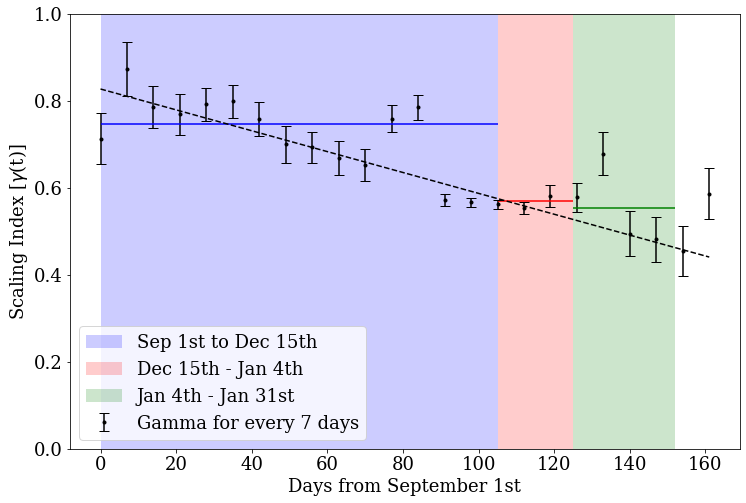

In [7]:
#plot data
plt.figure(figsize=(12,8))
plt.errorbar(days_between_points*np.arange(len(gamma_t)), gamma_t, yerr=dgamma_t, fmt='.', capsize=5, color='k', label=f'Gamma for every {days_between_points} days')
days = days_between_points*np.arange(len(gamma_t)) 
plt.ylabel(r'Scaling Index [$\gamma$(t)]')#, plt.xlabel('Days from '+date_start)
plt.ylim(0,1)#, plt.legend() 

#fit linear function
def lin(x,a,b):
    return a*x+b
p, cov = curve_fit(lin, days, gamma_t, sigma=dgamma_t)
power = lin(np.arange(3,len(Nposi_all[date_start:date_end])-4), *p)

#plot fit
plt.plot(days, lin(days, *p), color='k', linestyle='dashed')

#This creates weekly lines
#now = dt.date(year=int(date_end[:4]), month = int(date_end[5:7]), day = int( date_end[8:] ))
#then = now + dt.timedelta(days=-(len(data_posi.loc[date_start:date_end].sum(axis=1)))+14 )
#for x in np.arange(0,165,7): #weeks
#    plt.axvline( x, ls='--', color='grey', alpha=0.2)    
# Plot monthly lines on first date
#d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
#for i in range(len(data_posi.loc[date_start:date_end].sum(axis=1))):
#    d_now = d_now + dt.timedelta(days=1)
#    if d_now.day == 1:
#        plt.axvline( i-12, ls='-', color='k', alpha=0.5)
    
#times = []; N_weeks = int(len(data_posi.loc[date_start:date_end].sum(axis=1))/14)
#for i in range(N_weeks):
#    times.append(then + dt.timedelta(days=14*i))
    
#plt.xticks(ticks=[14*i for i in range(N_weeks)], 
#           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times], rotation=30 );

#Mark the three periods ------------------------------------------------------------------
period1 = (0, (dt.date(2020, 12, 15)-dt.date(2020, 9, 1)).days )
plt.axvspan(*period1, facecolor='b', alpha=0.2, label='Sep 1st to Dec 15th')

period2 = ( period1[1], period1[1] + (dt.date(2021, 1, 4)-dt.date(2020, 12, 15)).days )
plt.axvspan(*period2, facecolor='r', alpha=0.2, label='Dec 15th - Jan 4th')

period3 = ( period2[1], period2[1] + (dt.date(2021, 1, 31)-dt.date(2021, 1, 4)).days )
plt.axvspan(*period3, facecolor='g', alpha=0.2, label='Jan 4th - Jan 31st')

plt.legend()
plt.xlabel('Days from September 1st')

# Find a constant gamma for each period  ------------------------------------------------- 
g1 = np.average(a=gamma_t[0:15], weights=dgamma_t[0:15])
plt.hlines(g1, *period1, color='b')

g2 = np.average(a=gamma_t[15:18], weights=dgamma_t[15:18])
plt.hlines(g2, *period2, color='r')

g3 = np.average(a=gamma_t[18:22], weights=dgamma_t[18:22])
plt.hlines(g3, *period3, color='g')

plt.show()
#plt.savefig('gamma_t_2.png', dpi=300)

Now we will plot the entire period, and mark the three periods.

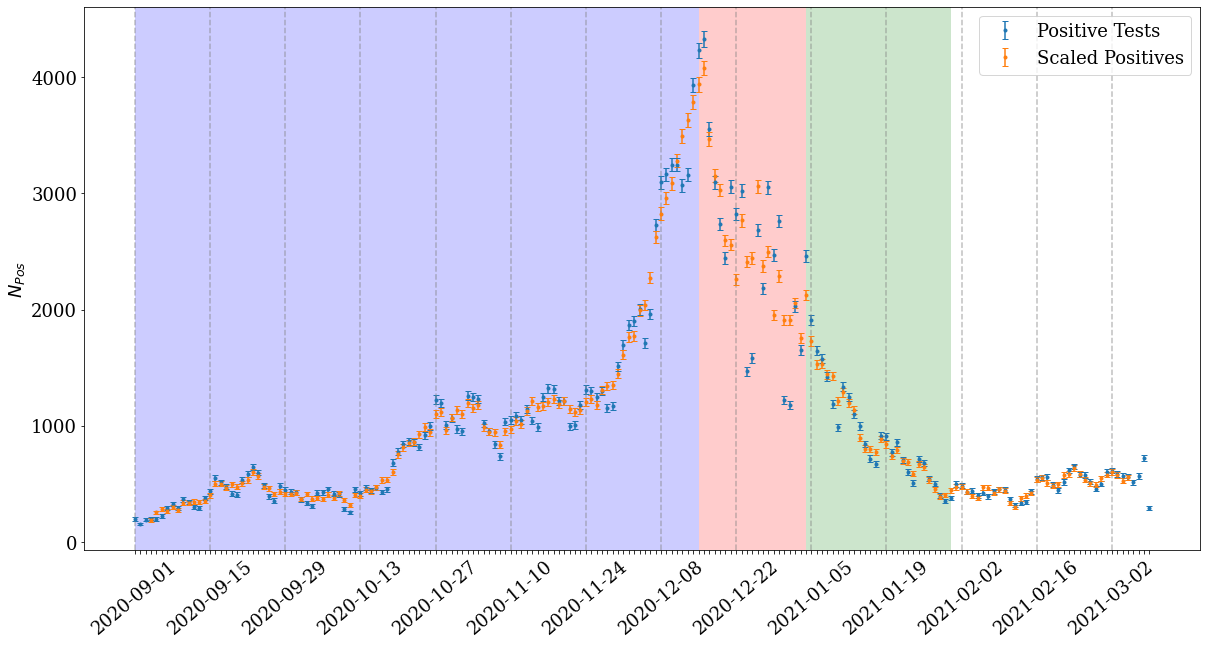

In [8]:
plt.figure(figsize=(20,10))
plt.errorbar(Nposi_all.index, Nposi_all[date_start:date_end], 
             yerr = eNposi_all[date_start:date_end], fmt='.', capsize=3, label='Positive Tests')

#includes date on x-label
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::14]))
for label in temp:
    label.set_visible(False)
for x in np.arange(0,len(Nposi_all[date_start:date_end]),14): #weeks
    plt.axvline( x, ls='--', color='grey', alpha=0.5)
    
    
mean_arr = []
for i in np.arange(3,len(Nposi_all[date_start:date_end])-4): 
    mean_arr.append( np.mean(Ntest_all[date_start:date_end][i-3:i+4]) )
SP = Nposi_all[3:-4] * (Ntest_all[date_start:date_end][3:-4]/mean_arr)**(-np.asarray(power) )


plt.errorbar(SP.index, SP[date_start:date_end], 
             yerr = np.sqrt(SP[date_start:date_end]), fmt='.', capsize=3, label='Scaled Positives')
plt.ylabel(r'$N_{Pos} $')
plt.xticks(rotation = 40); plt.legend();

#Mark the three periods ------------------------------------------------------------------
period1 = (0, (dt.date(2020, 12, 15)-dt.date(2020, 9, 1)).days )
plt.axvspan(*period1, facecolor='b', alpha=0.2, label='Sep 1st to Dec 15th')

period2 = ( period1[1], period1[1] + (dt.date(2021, 1, 4)-dt.date(2020, 12, 15)).days )
plt.axvspan(*period2, facecolor='r', alpha=0.2, label='Dec 15th - Jan 4th')

period3 = ( period2[1], period2[1] + (dt.date(2021, 1, 31)-dt.date(2021, 1, 4)).days )
plt.axvspan(*period3, facecolor='g', alpha=0.2, label='Jan 4th - Jan 31st')

plt.show()
#plt.savefig('Scaled_pos.png', dpi=300)

# Weekly corrections
Now that we have determined gamma we can look to determine the weekly corrections. We have gamma as a linear function, where the varying values of gamma are saved in the variable ``power``. Furthermore we have (from another script? that if we chose gamma to constant it is assigned the value of -0.56). I have also determined an average gamma for each period. We will start by looking into the last to options of use of gamma.

## With a value of gamma for each period.
First we need to define a function that can find the weekly corrections. The idea behind the weekly correction is that no one day is special. Say we want to correct a given day, we use the three days before and the three days after, and find a weighted average of how many scaled positives we would expect that day ``N_exp``, and compare it to how many scaled positives observed that day ``N_obs``. We can then find the correction as:
$$ \Delta f = \frac{N_{obs}}{N_{exp}} - 1 $$

If we do this for all days in each period (minus 3 on each side ?), we will get a table we can divide into the 7 weekdays. For all mondays in the period we will have a list of corrections along with their uncertainty, we can then compute a weighted average of those to obtain a correction factor for each day. This correction can be used on later data by multiplying with ``1+correction``.

As a sanity check we will plot the correction for each week on top of each other to see if they change significantly from one period to another.


Notes:
- Do we need the error on the geometric mean? I have computed but im confused as to how to use it.
- When calculating the error on the mean, n is different for each day, this needs to be adjusted
- When computing the mean, it weighs all inut the same, this should be replaced with a weighted average, but i need to figure out to get the errors first. We have the error on the expected SP and thus need to do error propagation to find the error on the observed SP. These can then be combined into the error on the frac.
- So far we have corrected by multiplying by 1+corr, should we instead divide by 1+corr?

In [9]:
def week_correction(dato_start, dato_end, gamma):
    """
    dato_start, dato_end = start day and en day of period we will analise. On the form 'year-month-date'.
                           Notice the corrections we will calculate will remove three days from each side
                           of this period to be able to compute the geometric mean
    gamma = the power for the given period. Constant.
    """
    
    # Extract data from the time period
    P_all = data_posi.loc[dato_start:dato_end].sum(axis=1)
    eP_all = np.sqrt(P_all)
    
    T_all = data_test.loc[dato_start:dato_end].sum(axis=1)
    eT_all = np.sqrt(T_all)
    T_mean = T_all.mean()
    
    # Find mean of tests performed, to use as T in the formula to find scaled positives SP
    # The mean is found by looking at three days on each side
        #mean_arr = []
        #for i in np.arange(3, len(P_all)-4): 
        #mean_arr.append( np.mean(T_all[i-3:i+4]) )
    
    # Find observed scaled positives
    SP_obs = P_all * (T_all/T_mean)**(-gamma)
    
    # Find expected scaled positives as the geometric mean of three days on each side
    SP_exp = np.zeros_like(SP_obs[6:]) #remove the six days on each day we dont use
    eSP_exp = np.zeros_like(SP_obs[6:])
    
    n = 7 #number of days we compute the mean from = 2*3+1

    for i in np.arange(3,len(SP_obs)-3): 
        
        # Geometric mean
        SP_exp[i-3] = (np.prod(SP_obs[i-3:i+4]))**(1/n) 
        
        # Error on geometric mean - from https://en.wikipedia.org/wiki/Geometric_standard_deviation
        eSP_exp[i-3] = np.exp( np.sqrt( np.sum( np.log(SP_obs[i-3:i+4])**2/n ) ) )
    
    # Fractional corrections --------------------------------------------------------------
    
    # Find number of weeks (rows in our matrix of size (weeks,7) ): +1 to make sure we have enough
    nrows = len(SP_exp) // 7 + 1

    # Create two arrays with nan, so elements not filled in will not contribute to the weighted average
    SP_obs_arr = np.empty(nrows * 7)
    SP_obs_arr[:] = np.nan
    
    SP_exp_arr = np.empty(nrows * 7)
    SP_exp_arr[:] = np.nan
    
    # Find out which day of the week, the first element is (should be dato_start+3)
    first_weekday = dt.date(int(dato_start[:4]), int(dato_start[5:7]), int(dato_start[8:10])) + dt.timedelta(days=3)
    day_index = first_weekday.weekday() #this would be the index where to insert the first element
    
    # Fill in SP_obs and SP_exp into empty array so they will have the right shape, ie. if we start on a 
    # thursday the first 3 values will be np.nan    
    SP_obs_arr[day_index:day_index+len(SP_exp)] = SP_obs[3:-3]
    SP_exp_arr[day_index:day_index+len(SP_exp)] = SP_exp
    
    # Lets reshape the array into matrices of the form week x day
    SP_obs_mat = SP_obs_arr.reshape(nrows, 7)
    SP_exp_mat = SP_exp_arr.reshape(nrows, 7)
    
    # Lets display what we have gotten so far in a imshow plot, each column should be the same color ish
    # if not there are big deviations
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow( (SP_obs_mat - SP_exp_mat) / SP_exp_mat )
    fig.colorbar(im)
    
    # Find mean of the fractional correction for each weekday, ie along the axis 0 = rows
    mean = np.nanmean( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0)   #monday, tuesday, wednesday etc.
    std = np.nanstd( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0) / np.sqrt(nrows-1) 
    
    return mean, std

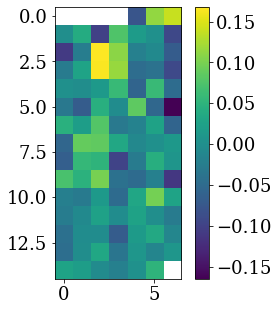

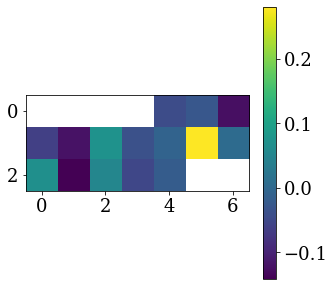

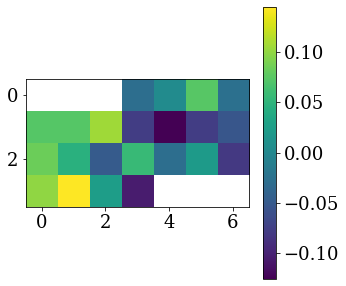

In [10]:
# Use on the first period
f1, e1 = week_correction(dato_start='2020-09-01', dato_end='2020-12-15', gamma=g1)

# Use on the second period
f2, e2 = week_correction(dato_start='2020-12-15', dato_end='2021-01-04', gamma=g2)

# Use on the third period
f3, e3 = week_correction(dato_start='2021-01-04', dato_end='2021-01-31', gamma=g3)

Kollonnerne i figurerne her bør have cirka samme farve, hvis der faktisk er en trend for hver ugedag. Det ligner der ikke der er? Men dette kan muligvis ændre sig hvis vi laver et weighted average, da det kan være nogle af værdierne er meget off men også har en stor usikkerhed.

In [15]:
# print korrektionerne
f1, f2, f3

(array([-0.0193257 ,  0.01194631,  0.04811278,  0.00339976, -0.00739968,
         0.01989761, -0.03385066]),
 array([ 0.00325436, -0.13075253,  0.06231342, -0.04371391, -0.02257255,
         0.12679609, -0.0581368 ]),
 array([ 0.08608449,  0.08804637,  0.02797482, -0.03837524, -0.04955935,
         0.0065209 , -0.05326805]))

Lets define a function to be able to visualise it:

In [12]:
def week_corr_plotter(mean, std, ax, lbl=None, col='blue'): 
    
    ax.errorbar(np.arange(len(mean)), mean, yerr=std, fmt='.', capsize=10, label=lbl, color=col)
    ax.legend()
    ax.set_ylabel('Fractional Deviation')
    ax.hlines(0, 0, 6, ls='--', color='k')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=25);

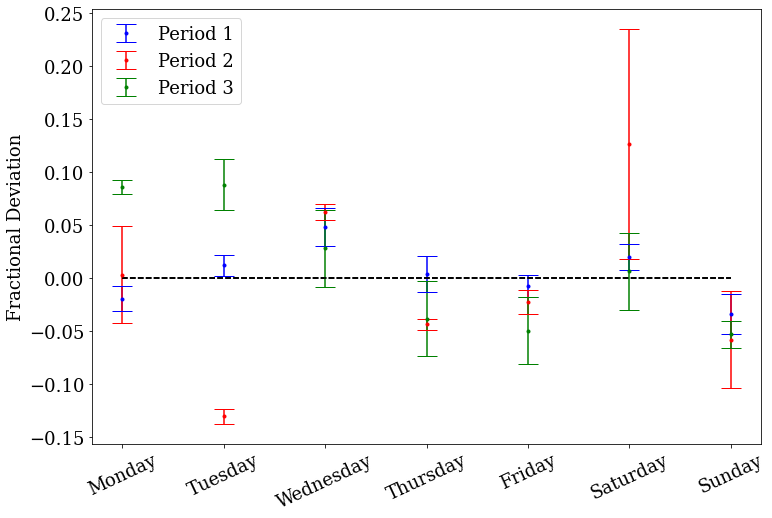

In [13]:
fig,ax=plt.subplots(figsize=(12,8))
week_corr_plotter(f1, e1, ax,'Period 1', col='blue')
week_corr_plotter(f2, e2, ax,'Period 2', col='red')
week_corr_plotter(f3, e3, ax,'Period 3', col='green')